<a href="https://colab.research.google.com/github/BryanDYang/BYFXApplication/blob/master/Energy_Project_ETL%2BEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-Processing

## Setup

Run the cell below to import necesary modules.

In [1]:
# For asynchronous requests
import asyncio
import aiohttp
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import requests
import time
import json
from sqlalchemy import create_engine



The exercises make use of the following datasets:
1.  `insurance` - A modified version of the [Automobile dataset](https://drive.google.com/a/sas.upenn.edu/file/d/1QgyhseW8t7luFPnAlB15n6_v9vpqf7Tr/view?usp=sharing) dataset maintained by the UCI Machine Learning Repository *(Same dataset used in EDA exercises)*
2. `models` - A modified version of [a dataset of car makes and models](https://drive.google.com/open?id=1a-ymSBOfF_LbnYvd4ZgISK_SzUoH47MI) compiled by Github user n8barr

Import these datasets to the notebook using the data importation procedure outlined in the [EDA tutorial](https://drive.google.com/open?id=1Cy3izai9zLQYTCTQF9IwkcuLmNArcKZO). First, add them to your Google Drive using the links above, then mount your Drive to the notebook by running the cell below.

In [2]:
prefix = '/content/drive'
from google.colab import drive
drive.mount(prefix, force_remount=True)

Mounted at /content/drive


In the cell below, copy the paths to the `insurance` and `models` datasets in your Drive to the variables `insurance_path` and `models_path` respectively. Then run the cell to load them into `DataFrames` named `insurance` and `models`.

In [5]:
energy_path = '/content/drive/My Drive/CIS5500/owid-energy-data.csv'
energy = pd.read_csv(energy_path)
energy.shape

(21812, 129)

In [ ]:
energy.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [ ]:
energy.dtypes

,0
country,object
year,int64
iso_code,object
population,float64
gdp,float64
...,...
wind_elec_per_capita,float64
wind_electricity,float64
wind_energy_per_capita,float64
wind_share_elec,float64


## Missing Values

As you saw in the EDA exercises, several columns in the `insurance` dataset have missing values. Below, you'll remove or replace these.

First, remove all rows in `insurance` missing `price`, `num_doors`, or `normalized_losses`

In [ ]:
energy.isnull().sum().sum()

1892712

In [ ]:
energy.shape[0] * energy.shape[1]

2813748

This data source may not be suitable since over 50% data points are missing.
Given the time series nature of the energy data, it would be a task of imputing missing values. Therefore we'll use some other data source for the project.

# EDA for the EIA retail-sales data

In [ ]:
# Initial API request test to understand the documentation
# API Documentation:
# https://www.eia.gov/opendata/documentation.php
# API URL
url = "https://api.eia.gov/v2/electricity/retail-sales/data/"

# EIA API key
api_key = 'd0lKHcPyVmConSgESOzcOX5PFntE6sSAfeXL3SwX'

# API parameters as specified by the EIA documentation
params = {
    "frequency": "monthly",
    "data": [
        "customers",
        "price",
        "revenue",
        "sales"
    ],
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "start": "2001-01",
    "end": "2024-07",
    "offset": 0,
    "length": 5000  # Maximum number of rows per API call
}

# Convert params to a JSON string
headers = {
    'X-Params': json.dumps(params),
    'X-API-Key': api_key
}

# Make the GET request to the API using headers
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()

    # Extract relevant data (check JSON structure to find correct key)
    if 'response' in data and 'data' in data['response']:
        df = pd.DataFrame(data['response']['data'])
        # Display the dataframe
        print(df.head())

        # Save the raw JSON response to a file
        with open('electricity_sales_data.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

        print("Data has been saved to electricity_sales data.json.")
    else:
        print("Data not found in the expected format.")
else:
    print(f"Failed to retrieve data: {response.status_code}")

    period stateid       stateDescription sectorid   sectorName customers  \
0  2024-07      AL                Alabama      ALL  all sectors   2802231   
1  2024-07    PACN  Pacific Noncontiguous      RES  residential    746810   
2  2024-07    PACN  Pacific Noncontiguous      OTH        other      None   
3  2024-07    PACN  Pacific Noncontiguous      IND   industrial      2033   
4  2024-07    PACN  Pacific Noncontiguous      COM   commercial    117301   

   price     revenue       sales      customers-units  \
0  12.13  1060.24611  8742.89046  number of customers   
1  36.06   134.81738   373.90613  number of customers   
2   None        None        None  number of customers   
3  29.29    122.3332   417.63634  number of customers   
4  30.06   135.93904   452.15779  number of customers   

               price-units    revenue-units             sales-units  
0  cents per kilowatt-hour  million dollars  million kilowatt hours  
1  cents per kilowatt-hour  million dollars  million k

In [4]:
# Pulling max data
# API URL
url = "https://api.eia.gov/v2/electricity/retail-sales/data/"

# EIA API key
api_key = 'd0lKHcPyVmConSgESOzcOX5PFntE6sSAfeXL3SwX'

# Initialize variables
offset = 0
limit = 5000  # Maximum number of rows per API call
all_data = []  # List to store all the rows
last_batch_data = None  # To check for duplicate data

# Loop to paginate through the API results
while True:
    # API parameters as specified by the EIA documentation
    params = {
      "frequency": "monthly",
      "data": [
          "customers",
          "price",
          "revenue",
          "sales"
      ],
      "sort": [
          {
              "column": "period",
              "direction": "desc"
          }
      ],
      # Check the last 10 years of data
      "start": "2014-01",
      "end": "2024-07",
      "offset": offset,
      "length": limit  # Maximum number of rows per API call
    }

    # Convert params to a JSON string
    headers = {
      'X-Params': json.dumps(params),
      'X-API-Key': api_key
    }

    # Measure the time for the request
    start_time = time.time()

    # Make the GET request to the API using headers
    response = requests.get(url, headers=headers)

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"Batch {offset // limit + 1} retrieved in {elapsed_time:.2f} seconds, Offset: {offset}")

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

        # Extract relevant data (check JSON structure to find correct key)
        if 'response' in data and 'data' in data['response']:
            batch_data = data['response']['data']
            print(f"Batch {offset // limit + 1} size: {len(batch_data)} rows")

            # Check for infinite loop by comparing with the last batch data
            if batch_data == last_batch_data:
                print("Duplicate batch detected! Breaking out of the loop to avoid infinite requests.")
                break
            last_batch_data = batch_data

            all_data.extend(batch_data)

            # Check if the batch size is less than the limit, indicating the last page
            if len(batch_data) < limit:
                print("Last batch retrieved. Ending the data fetch.")
                break

            # Increment offset for the next batch
            offset += limit
        else:
            print("Data not found in the expected format.")
            break
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        break

# Convert the collected data into a DataFrame
df = pd.DataFrame(all_data)

# Display total rows and attributes
total_rows = len(df)
total_attributes = len(df.columns)
print(f"Total Rows: {total_rows}")
print(f"Total Attributes: {total_attributes}")

Batch 1 retrieved in 1.09 seconds, Offset: 0
Batch 1 size: 5000 rows
Batch 2 retrieved in 0.87 seconds, Offset: 5000
Batch 2 size: 5000 rows
Batch 3 retrieved in 1.76 seconds, Offset: 10000
Batch 3 size: 5000 rows
Batch 4 retrieved in 0.99 seconds, Offset: 15000
Batch 4 size: 5000 rows
Batch 5 retrieved in 1.00 seconds, Offset: 20000
Batch 5 size: 5000 rows
Batch 6 retrieved in 0.93 seconds, Offset: 25000
Batch 6 size: 5000 rows
Batch 7 retrieved in 0.89 seconds, Offset: 30000
Batch 7 size: 5000 rows
Batch 8 retrieved in 1.02 seconds, Offset: 35000
Batch 8 size: 5000 rows
Batch 9 retrieved in 0.97 seconds, Offset: 40000
Batch 9 size: 5000 rows
Batch 10 retrieved in 0.87 seconds, Offset: 45000
Batch 10 size: 2244 rows
Last batch retrieved. Ending the data fetch.
Total Rows: 47244
Total Attributes: 13


In [5]:
df

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
0,2024-07,AL,Alabama,ALL,all sectors,2802231,12.13,1060.24611,8742.89046,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
1,2024-07,PACN,Pacific Noncontiguous,RES,residential,746810,36.06,134.81738,373.90613,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
2,2024-07,PACN,Pacific Noncontiguous,OTH,other,None,None,None,None,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
3,2024-07,PACN,Pacific Noncontiguous,IND,industrial,2033,29.29,122.3332,417.63634,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
4,2024-07,PACN,Pacific Noncontiguous,COM,commercial,117301,30.06,135.93904,452.15779,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47239,2014-01,SC,South Carolina,ALL,all sectors,2493733,9.8,749.02676,7643.65525,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47240,2014-01,SC,South Carolina,COM,commercial,347321,10.17,194.24404,1909.91362,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47241,2014-01,SC,South Carolina,IND,industrial,4510,6.61,155.27492,2349.54406,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47242,2014-01,SC,South Carolina,OTH,other,None,None,None,None,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours


In [6]:
df.tail()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units
47239,2014-01,SC,South Carolina,ALL,all sectors,2493733,9.8,749.02676,7643.65525,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47240,2014-01,SC,South Carolina,COM,commercial,347321,10.17,194.24404,1909.91362,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47241,2014-01,SC,South Carolina,IND,industrial,4510,6.61,155.27492,2349.54406,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47242,2014-01,SC,South Carolina,OTH,other,None,None,None,None,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours
47243,2014-01,SC,South Carolina,RES,residential,2141902,11.81,399.5078,3384.19758,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours


In [7]:
df.dtypes

,0
period,object
stateid,object
stateDescription,object
sectorid,object
sectorName,object
customers,object
price,object
revenue,object
sales,object
customers-units,object


In [8]:
# Convert `price`, `revenue`, `sales`, `customers` columns to numeric types
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['revene'] = pd.to_numeric(df['revenue'], errors='coerce')
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
df['customers'] = pd.to_numeric(df['customers'], errors='coerce')

# Display the updated DataFrame
df.head(), df.dtypes

(    period stateid       stateDescription sectorid   sectorName  customers  \
 0  2024-07      AL                Alabama      ALL  all sectors  2802231.0   
 1  2024-07    PACN  Pacific Noncontiguous      RES  residential   746810.0   
 2  2024-07    PACN  Pacific Noncontiguous      OTH        other        NaN   
 3  2024-07    PACN  Pacific Noncontiguous      IND   industrial     2033.0   
 4  2024-07    PACN  Pacific Noncontiguous      COM   commercial   117301.0   
 
    price     revenue       sales      customers-units  \
 0  12.13  1060.24611  8742.89046  number of customers   
 1  36.06   134.81738   373.90613  number of customers   
 2    NaN        None         NaN  number of customers   
 3  29.29    122.3332   417.63634  number of customers   
 4  30.06   135.93904   452.15779  number of customers   
 
                price-units    revenue-units             sales-units  \
 0  cents per kilowatt-hour  million dollars  million kilowatt hours   
 1  cents per kilowatt-hour  m

In [9]:
df.sample()

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,revene
27902,2018-04,UT,Utah,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN


In [10]:
df.shape

(47244, 14)

In [11]:
df.isnull().sum().sum()

39395

In [12]:
df.shape[0] * df.shape[1]

661416

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47244 entries, 0 to 47243
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   period            47244 non-null  object 
 1   stateid           47244 non-null  object 
 2   stateDescription  47244 non-null  object 
 3   sectorid          47244 non-null  object 
 4   sectorName        47244 non-null  object 
 5   customers         39365 non-null  float64
 6   price             39365 non-null  float64
 7   revenue           39365 non-null  object 
 8   sales             39365 non-null  float64
 9   customers-units   47244 non-null  object 
 10  price-units       47244 non-null  object 
 11  revenue-units     47244 non-null  object 
 12  sales-units       47244 non-null  object 
 13  revene            39365 non-null  float64
dtypes: float64(4), object(10)
memory usage: 5.0+ MB


In [14]:
df.describe(include='all')

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,revene
count,47244,47244,47244,47244,47244,3.936500e+04,39365.000000,39365,39365.000000,47244,47244,47244,47244,39365.000000
unique,127,62,62,6,6,NaN,NaN,35498,NaN,1,1,1,1,NaN
top,2024-07,HI,Hawaii,OTH,other,NaN,NaN,0,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
freq,372,792,792,7879,7879,NaN,NaN,3052,NaN,47244,47244,47244,47244,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.978734e+06,10.570825,NaN,6121.043979,NaN,NaN,NaN,NaN,676.303015
std,NaN,NaN,NaN,NaN,NaN,1.224370e+07,5.635641,NaN,21861.881981,NaN,NaN,NaN,NaN,2467.690266
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,-0.000010
25%,NaN,NaN,NaN,NaN,NaN,5.452000e+03,7.840000,NaN,274.714940,NaN,NaN,NaN,NaN,35.574590
50%,NaN,NaN,NaN,NaN,NaN,3.086830e+05,10.030000,NaN,1483.193830,NaN,NaN,NaN,NaN,143.714830
75%,NaN,NaN,NaN,NaN,NaN,2.069473e+06,12.610000,NaN,4413.295640,NaN,NaN,NaN,NaN,494.480400


In [15]:
df.isnull().sum()

,0
period,0
stateid,0
stateDescription,0
sectorid,0
sectorName,0
customers,7879
price,7879
revenue,7879
sales,7879
customers-units,0


Visually inspect the null tuples for sanity check.

In [16]:
# Display rows with any null values
null_rows = df[df.isnull().any(axis=1)]
null_rows

,period,stateid,stateDescription,sectorid,sectorName,customers,price,revenue,sales,customers-units,price-units,revenue-units,sales-units,revene
2,2024-07,PACN,Pacific Noncontiguous,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
8,2024-07,PACC,Pacific Contiguous,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
14,2024-07,MTN,Mountain,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
20,2024-07,WSC,West South Central,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
26,2024-07,ESC,East South Central,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47216,2014-01,ID,Idaho,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
47223,2014-01,ND,North Dakota,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
47229,2014-01,OH,Ohio,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN
47235,2014-01,OK,Oklahoma,OTH,other,NaN,NaN,None,NaN,number of customers,cents per kilowatt-hour,million dollars,million kilowatt hours,NaN


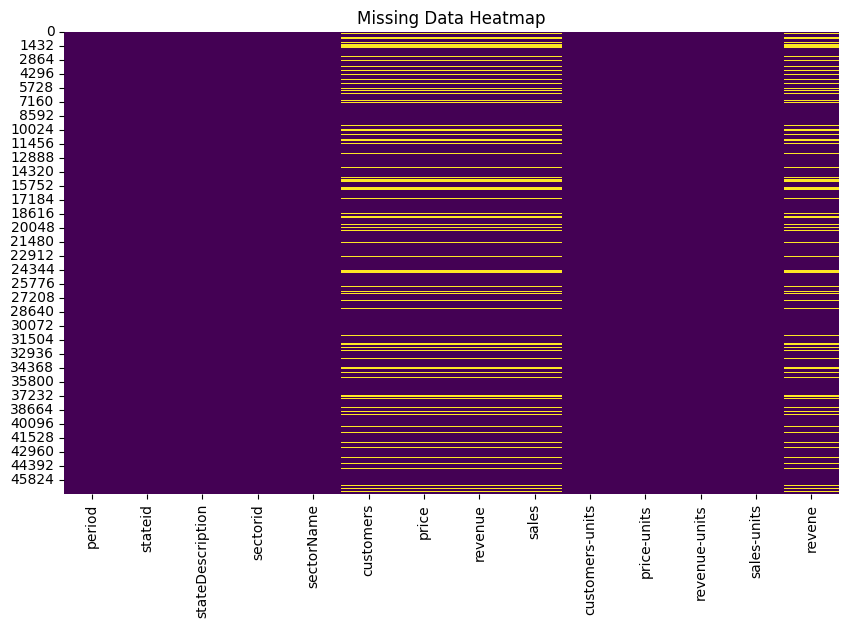

In [17]:
# Heatmap for null values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Null values are fragmented. It is a good candidate for forward/backward fill imputation.

Since the gaps are scattered rather than covering entire block, using this method will retain the flow of data trends, which is beneficial for time series data like this one.

Also, when missing values are filled based on nearby values, it minimizes the distortion in data, especially if consecutive entires are closely related like monthly data in this ase.

In [18]:
# Forward fill followed by backward fill (to handle start/end gaps)
df = df.ffill().bfill()

In [21]:
# Rechecking the null values
df.isnull().sum()

,0
period,0
stateid,0
stateDescription,0
sectorid,0
sectorName,0
customers,0
price,0
revenue,0
sales,0
customers-units,0


In [19]:
df['sectorName'].value_counts()

,count
sectorName,
other,7879
industrial,7878
commercial,7875
all sectors,7871
residential,7871
transportation,7870


In [20]:
df['stateDescription'].value_counts()

,count
stateDescription,
Hawaii,792
Iowa,786
Indiana,785
Illinois,783
Connecticut,780
...,...
New Mexico,744
North Carolina,744
New York,744


Data Distribution and Visualization

Numeric Data Distribution

Histogram: Use matplotlib/seaborn to plot histograms for numerical columns

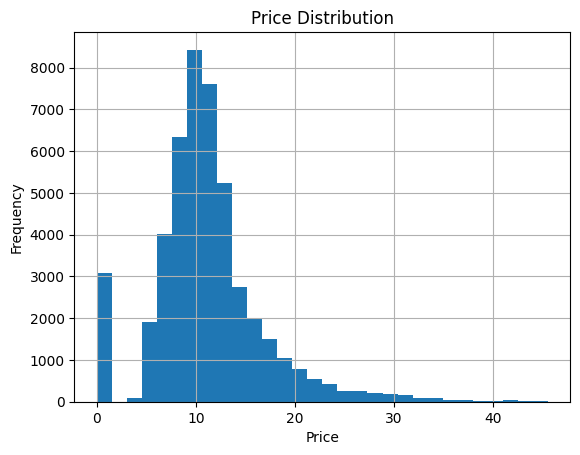

In [50]:
import matplotlib.pyplot as plt
df['price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.show()

In [51]:
# Basic statistics for the 'price' column
print(df['price'].describe())

count    47244.000000
mean        11.191643
std          5.742212
min          0.000000
25%          8.270000
50%         10.600000
75%         13.200000
max         45.590000
Name: price, dtype: float64


Categorical Data Distribution

Bar Plot: Visualize categorical distributions

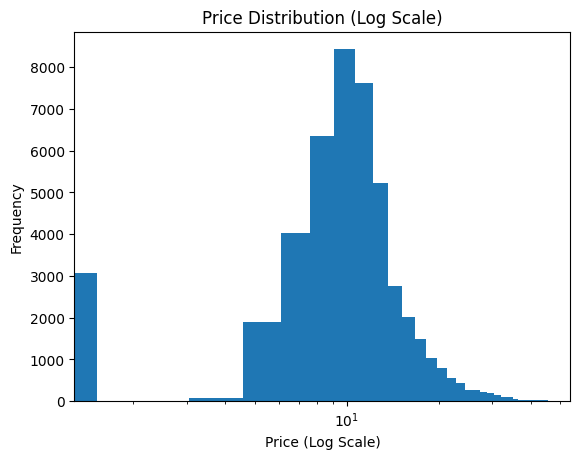

In [52]:
# Plot the histogram with a log scale
# Reducing the impact of extreme values
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].plot(kind='hist', bins=30, logx=True)
plt.xlabel('Price (Log Scale)')
plt.ylabel('Frequency')
plt.title('Price Distribution (Log Scale)')
plt.show()

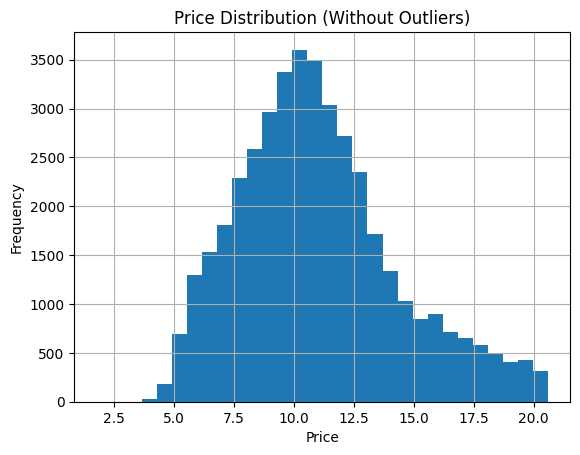

In [53]:
# Remove outliers using the IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define a range to exclude extreme outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Plot the histogram without extreme outliers
df_filtered['price'].hist(bins=30)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution (Without Outliers)')
plt.show()

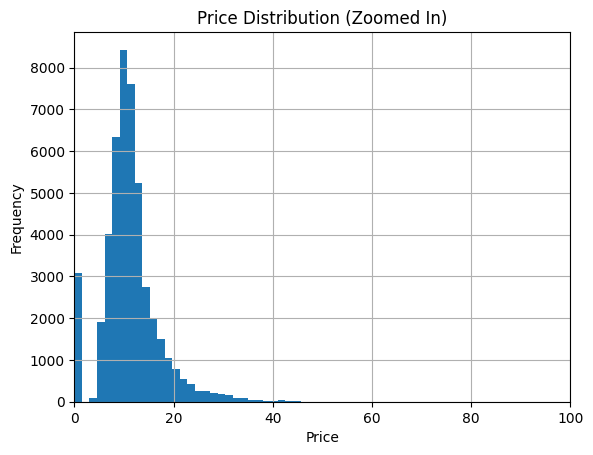

In [54]:
# Plot the histogram with a limited range
df['price'].hist(bins=30)
plt.xlim(0, 100)  # Adjust the range as needed
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution (Zoomed In)')
plt.show()

<ipython-input-55-dd92710f63f4>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['price'], shade=True)


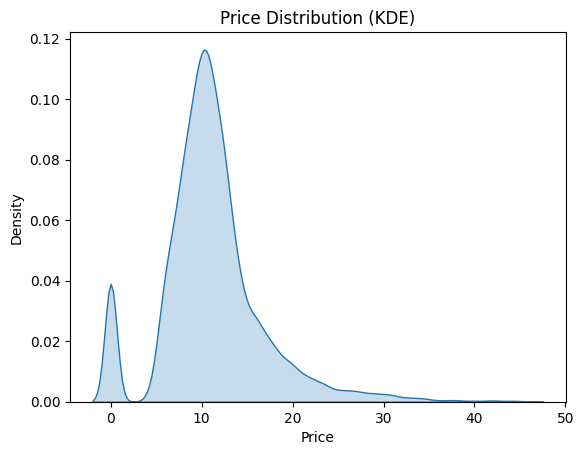

In [55]:
import seaborn as sns

# Plot Kernel Density Estimate (KDE) Plot
# To get a smooth estimate of the distribution
sns.kdeplot(df['price'], shade=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('Price Distribution (KDE)')
plt.show()

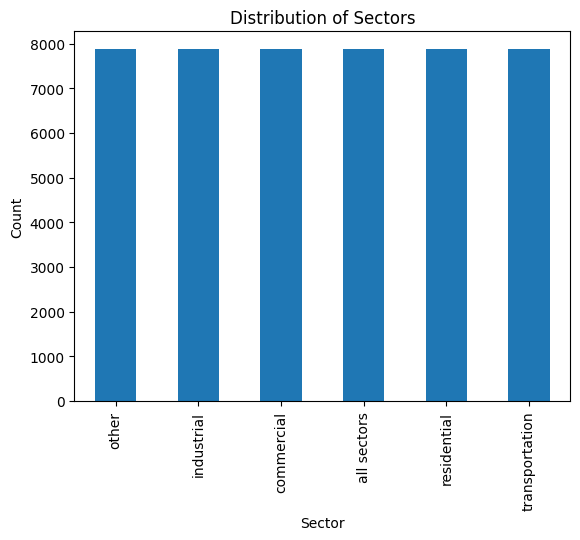

In [56]:
df['sectorName'].value_counts().plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Distribution of Sectors')
plt.show()

Box Plot: Visualize the distribution and outliers in a numerical column

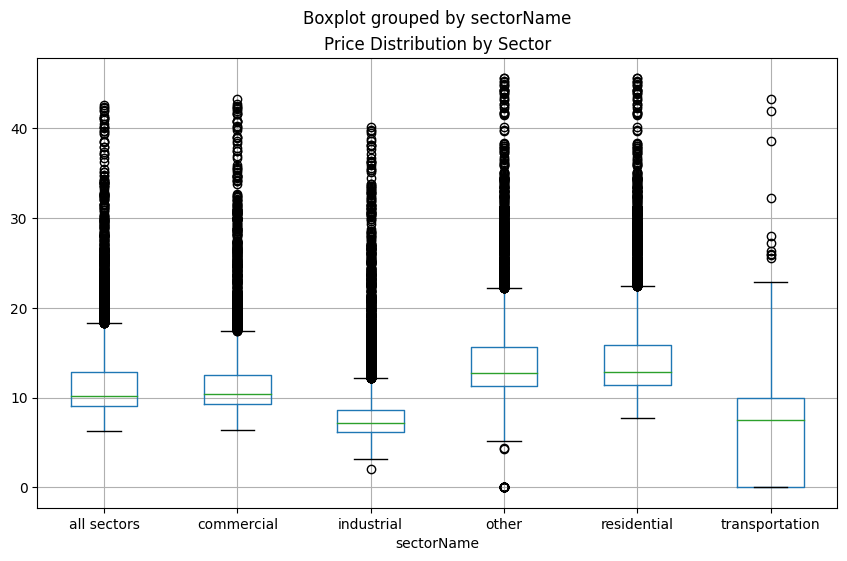

In [57]:
# Remove rows with NaN values in 'price' column for boxplot
df_boxplot = df.dropna(subset=['price'])

# Create boxplot
df_boxplot.boxplot(column='price', by='sectorName', figsize=(10, 6))
plt.title('Price Distribution by Sector')
plt.show()

In [58]:
# Save the collected data as a JSON format
output_file = '/content/drive/My Drive/eia_elec_sales.json'
with open(output_file, 'w') as json_file:
    json.dump(data, json_file, indent=4)
    print("Data has been saved to eia_elec_sales.json.")

Data has been saved to electricity_sales_data.json.


# EDA for the EIA Monthly and annual electric power operations by state, sector, and energy source data

In [ ]:
# API URL and Key
url = "https://api.eia.gov/v2/electricity/electric-power-operational-data/data/"
api_key = 'd0lKHcPyVmConSgESOzcOX5PFntE6sSAfeXL3SwX'
limit = 5000  # Adjusted limit for each API call
output_file = '/content/drive/My Drive/eia_energy_consumption.json'

# Function to make a single API request
async def fetch_data(session, offset):
    params = {
        "frequency": "monthly",
        "data": [
            "ash-content",
            "consumption-for-eg",
            "consumption-for-eg-btu",
            "consumption-uto",
            "consumption-uto-btu",
            "cost",
            "cost-per-btu",
            "generation",
            "heat-content",
            "receipts",
            "receipts-btu",
            "stocks",
            "sulfur-content",
            "total-consumption",
            "total-consumption-btu"
        ],
        "sort": [{"column": "period", "direction": "desc"}],
        "start": "2014-01",
        "end": "2024-07",
        "offset": offset,
        "length": limit
    }

    headers = {
        'X-Params': json.dumps(params),
        'X-API-Key': api_key
    }

    try:
        async with session.get(url, headers=headers) as response:
            if response.status == 200:
                data = await response.json()
                batch_data = data.get('response', {}).get('data', [])
                return batch_data
            else:
                print(f"Failed to retrieve data at offset {offset}: Status {response.status}")
                return None
    except Exception as e:
        print(f"Exception occurred for offset {offset}: {e}")
        return None

# Asynchronous function to manage multiple API requests
async def fetch_all_data():
    offset = 0
    all_data = []
    tasks = []
    async with aiohttp.ClientSession() as session:
        while True:
            # Create a task for each batch
            task = asyncio.create_task(fetch_data(session, offset))
            tasks.append(task)

            # Increment the offset for the next batch
            offset += limit

            # Break loop if enough tasks are queued (you can adjust this number)
            if len(tasks) >= 20:  # Fetch 20 batches concurrently
                break

        # Wait for all tasks to complete
        results = await asyncio.gather(*tasks)

        # Collect all batch data
        for batch_data in results:
            if batch_data:
              all_data.extend(batch_data)

        # Save all the collected data to JSON file
        with open(output_file, 'w') as json_file:
            json.dump(all_data, json_file, indent=4)
        print(f"Data has been saved to {output_file}.")

In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Main function to run the async fetcher
def main():
    asyncio.run(fetch_all_data())

# Execute the main function
if __name__ == '__main__':
    main()

Data has been saved to /content/drive/My Drive/eia_data_async.json.


In [ ]:
# Check if the file exists and its size
file_path = '/content/drive/My Drive/eia_energy_consumption.json'
if os.path.exists(file_path):
    print(f"File found at: {file_path}, Size: {os.path.getsize(file_path)} bytes")
else:
    print("File not found.")

File found at: /content/drive/My Drive/eia_data_async.json, Size: 153832068 bytes


In [10]:
# Load JSON data into a DataFrame
output_file = '/content/drive/My Drive/eia_energy_consumption.json'
df = pd.read_json(output_file)

# Display the head of the DataFrame
df.head()

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,ash-content,ash-content-units,consumption-for-eg,...,receipts-btu,receipts-btu-units,stocks,stocks-units,sulfur-content,sulfur-content-units,total-consumption,total-consumption-units,total-consumption-btu,total-consumption-btu-units
0,2024-07,CT,Connecticut,99,All Sectors,DPV,estimated small scale solar photovoltaic,NaN,percent,NaN,...,NaN,billion Btu,NaN,thousand physical units,NaN,percent,NaN,thousand physical units,NaN,million MMBtu
1,2024-07,PCN,Pacific Noncontiguous,90,Electric Power Sector Non-CHP,WOO,waste oil and other oils,NaN,percent,NaN,...,NaN,billion Btu,NaN,thousand barrels,NaN,percent,NaN,thousand barrels,NaN,million MMBtu
2,2024-07,PCN,Pacific Noncontiguous,90,Electric Power Sector Non-CHP,WOC,waste coal,7.6,percent,27.929,...,114.6068,billion Btu,NaN,thousand short tons,0.15,percent,27.929,thousand short tons,0.43569,million MMBtu
3,2024-07,PCN,Pacific Noncontiguous,90,Electric Power Sector Non-CHP,WNT,onshore wind turbine,NaN,percent,0.000,...,NaN,billion Btu,NaN,thousand physical units,NaN,percent,0.000,thousand physical units,0.24887,million MMBtu
4,2024-07,PCN,Pacific Noncontiguous,90,Electric Power Sector Non-CHP,WND,wind,NaN,percent,0.000,...,NaN,billion Btu,NaN,thousand physical units,NaN,percent,0.000,thousand physical units,0.24887,million MMBtu


# Understand Data Structure

- Data Types
- Summary Statistics

In [ ]:
df.dtypes

,0
period,object
location,object
stateDescription,object
sectorid,int64
sectorDescription,object
fueltypeid,object
fuelTypeDescription,object
ash-content,float64
ash-content-units,object
consumption-for-eg,float64


In [ ]:
df.describe(include='all')

,period,location,stateDescription,sectorid,sectorDescription,fueltypeid,fuelTypeDescription,ash-content,ash-content-units,consumption-for-eg,...,receipts-btu,receipts-btu-units,stocks,stocks-units,sulfur-content,sulfur-content-units,total-consumption,total-consumption-units,total-consumption-btu,total-consumption-btu-units
count,100000,100000,100000,100000.00000,100000,100000,100000,9089.000000,100000,8.415900e+04,...,1.955900e+04,100000,8115.000000,100000,10421.000000,100000,8.415900e+04,100000,84159.000000,100000
unique,6,64,64,NaN,15,45,43,NaN,1,NaN,...,NaN,1,NaN,4,NaN,1,NaN,4,NaN,1
top,2024-04,US,U.S. Total,NaN,All Sectors,ALL,biomass,NaN,percent,NaN,...,NaN,billion Btu,NaN,thousand physical units,NaN,percent,NaN,thousand physical units,NaN,million MMBtu
freq,17506,4100,4100,NaN,13381,4424,7502,NaN,100000,NaN,...,NaN,100000,NaN,62040,NaN,100000,NaN,62040,NaN,100000
mean,NaN,NaN,NaN,59.70980,NaN,NaN,NaN,9.098457,NaN,2.482171e+03,...,2.463430e+04,NaN,3577.414563,NaN,1.207943,NaN,2.734552e+03,NaN,11.500074,NaN
std,NaN,NaN,NaN,45.09164,NaN,NaN,NaN,7.206197,NaN,3.035532e+04,...,9.249108e+04,NaN,17007.099188,NaN,1.177831,NaN,3.212252e+04,NaN,75.916916,NaN
min,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,0.000000,NaN,0.000000e+00,...,0.000000e+00,NaN,0.000000,NaN,0.000000,NaN,0.000000e+00,NaN,0.000000,NaN
25%,NaN,NaN,NaN,5.00000,NaN,NaN,NaN,5.500000,NaN,0.000000e+00,...,1.854320e+02,NaN,0.000000,NaN,0.350000,NaN,0.000000e+00,NaN,0.006830,NaN
50%,NaN,NaN,NaN,94.00000,NaN,NaN,NaN,8.020000,NaN,0.000000e+00,...,2.864343e+03,NaN,2.794000,NaN,0.590000,NaN,0.000000e+00,NaN,0.241570,NaN
75%,NaN,NaN,NaN,97.00000,NaN,NaN,NaN,9.600000,NaN,4.268750e+01,...,1.646938e+04,NaN,318.203000,NaN,2.010000,NaN,7.033900e+01,NaN,2.712810,NaN


# Identify Null Values
- Count Nulls
- Percentage of Missing Data

In [ ]:
# Count of null values
null_counts = df.isnull().sum()

# Percentage of missing data per column
missing_percentage = (df.isnull().sum()) / len(df) * 100

null_counts, missing_percentage

(period                              0
 location                            0
 stateDescription                    0
 sectorid                            0
 sectorDescription                   0
 fueltypeid                          0
 fuelTypeDescription                 0
 ash-content                     90911
 ash-content-units                   0
 consumption-for-eg              15841
 consumption-for-eg-units            0
 consumption-for-eg-btu          15841
 consumption-for-eg-btu-units        0
 consumption-uto                 15841
 consumption-uto-units               0
 consumption-uto-btu             15841
 consumption-uto-btu-units           0
 cost                            78348
 cost-units                          0
 cost-per-btu                    95227
 cost-per-btu-units                  0
 generation                      12848
 generation-units                    0
 heat-content                     6394
 heat-content-units                  0
 receipts                

# Visualize Missing Data


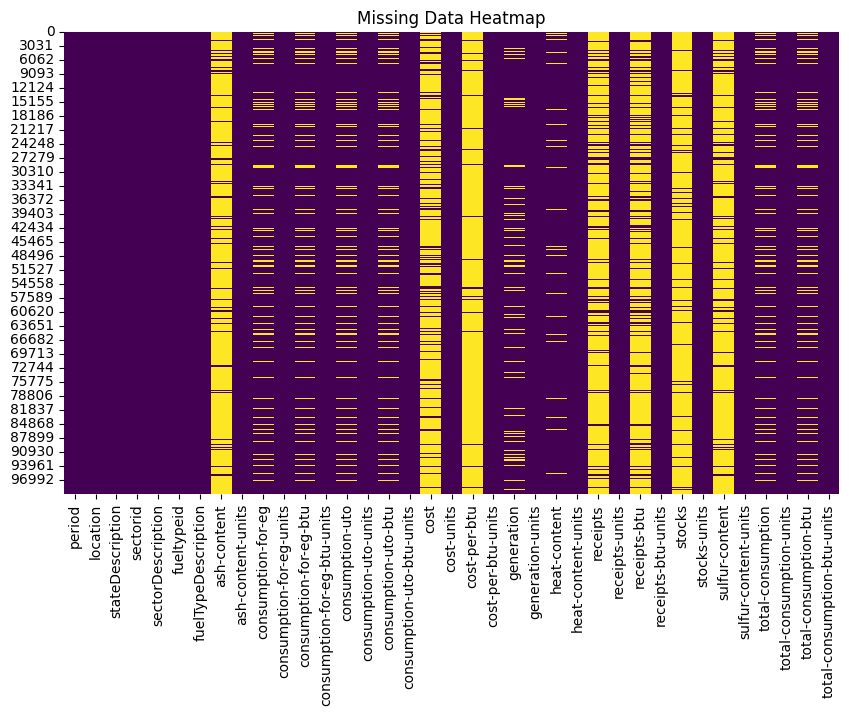

In [ ]:
# Heatmap for null values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# Identifying Duplicate Rows

In [19]:
# Count of duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count

48101

In [20]:
# Display duplicates if any
if duplicate_count > 0:
    print("Duplicate Rows:")
    print(df[df.duplicated()])
else:
    print("No duplicate rows found.")

Duplicate Rows:
          period location stateDescription  sectorid  \
5053  2024-07-01       90          Pacific        97   
5054  2024-07-01       90          Pacific        97   
5055  2024-07-01       90          Pacific        97   
5056  2024-07-01       90          Pacific        97   
5057  2024-07-01       90          Pacific        97   
...          ...      ...              ...       ...   
99995 2024-02-01       KY         Kentucky         1   
99996 2024-02-01       KS           Kansas        94   
99997 2024-02-01       KS           Kansas        94   
99998 2024-02-01       KS           Kansas        94   
99999 2024-02-01       KS           Kansas        94   

                 sectorDescription fueltypeid         fuelTypeDescription  \
5053                All Industrial        WWW        wood and wood wastes   
5054                All Industrial        WOO    waste oil and other oils   
5055                All Industrial        WNT        onshore wind turbine   
505

# Treating Null/Missing Values

- Columns with over 80% nulls: `ash-content`, `cost-per-btu`, `stocks`, `sulfur-content`, `receipts`, and `receipts-btu` contain too many nulls to be useful for most analyses. Given the high missing percentages of values, it's hard to impute them, even with domain knowledge, for meaningful values. Therefore, we'll drop these columns as well as related columns like `ash-content-units`.

- Columns with 10-20% nulls: `consumption-for-eg`, `generation`, `total-consumption`, `consumption-uto`, and `heat-content` have moderate percentage of missing values (10-20%). Here imputation methods can be helpful. Since all these columns are numerical type and the data is time-series, forward or backward fill can maintain trends over time.

- Columns with 5-10% nulls: columns with minimal nulls like `heat-content`, we can fill the missing values with similar approach to the moderate percentage of missing values.



In [11]:
# Drop columns with over 80% nulls from the dataframe
df = df.drop(columns=['ash-content',
                      'ash-content-units',
                      'cost-per-btu',
                      'cost-per-btu-units',
                      'stocks',
                      'stocks-units',
                      'sulfur-content',
                      'sulfur-content-units',
                      'receipts',
                      'receipts-units',
                      'receipts-btu',
                      'receipts-btu-units'])

In [12]:
# forward/backward fill to maintain the trends overtime
df = df.ffill().bfill()

In [13]:
# Count of null values
null_counts = df.isnull().sum()

# Percentage of missing data per column
missing_percentage = (df.isnull().sum()) / len(df) * 100

null_counts, missing_percentage

(period                          0
 location                        0
 stateDescription                0
 sectorid                        0
 sectorDescription               0
 fueltypeid                      0
 fuelTypeDescription             0
 ash-content-units               0
 consumption-for-eg              0
 consumption-for-eg-units        0
 consumption-for-eg-btu          0
 consumption-for-eg-btu-units    0
 consumption-uto                 0
 consumption-uto-units           0
 consumption-uto-btu             0
 consumption-uto-btu-units       0
 cost                            0
 cost-units                      0
 cost-per-btu-units              0
 generation                      0
 generation-units                0
 heat-content                    0
 heat-content-units              0
 receipts-units                  0
 receipts-btu-units              0
 stocks-units                    0
 sulfur-content-units            0
 total-consumption               0
 total-consumption-u

# Analyze Distribution of Key Columns
- For numerical columns, histogram/box plots for spotting skewness, outliers, and distribution shapel.

- For categorical columns, bar plots to reveal the frequency of different categories.

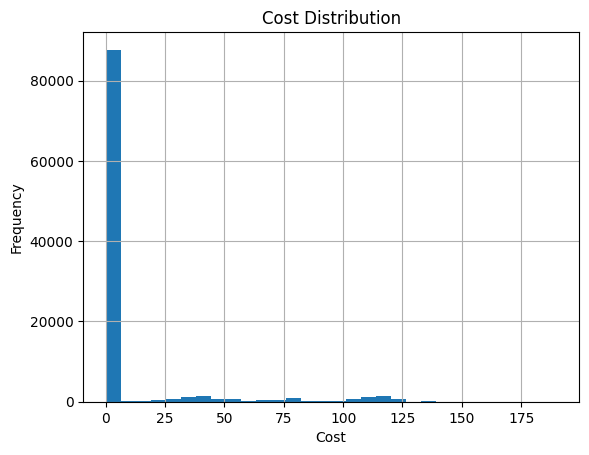

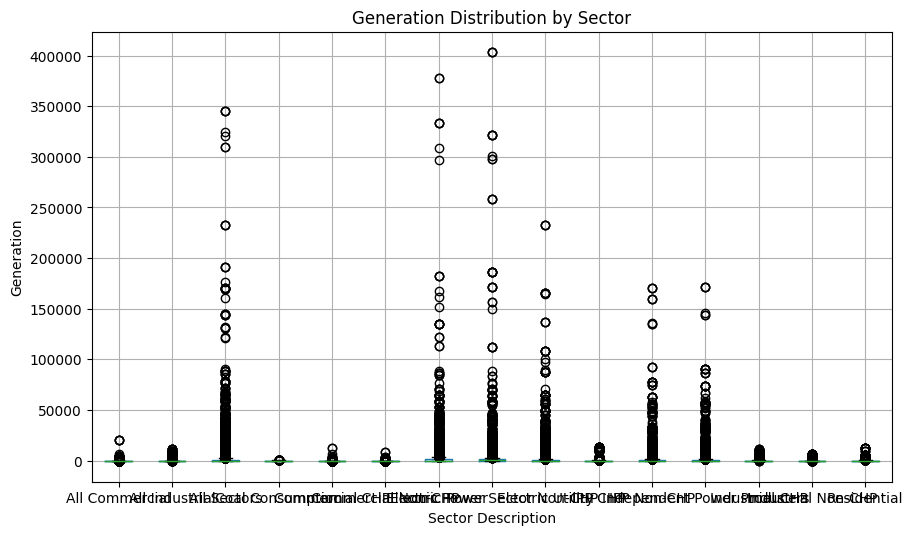

In [16]:
# Histogram of 'cost'
df['cost'].hist(bins=30)
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Cost Distribution')
plt.show()

# Boxplot to check for outliers in 'generation' by sector
df.boxplot(column='generation', by='sectorDescription', figsize=(10, 6))
plt.xlabel('Sector Description')
plt.ylabel('Generation')
plt.title('Generation Distribution by Sector')
plt.suptitle("")  # Suppress the default title
plt.xticks(rotation=90)
plt.show()

# Correlation Aanlysis

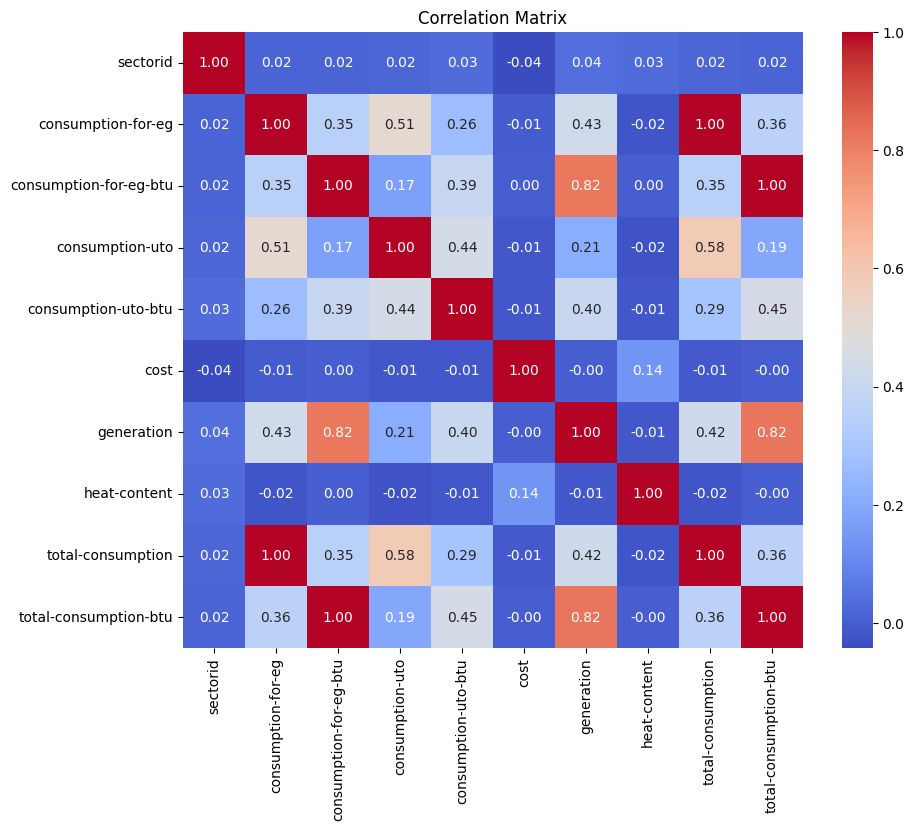

In [18]:
# Ensure 'period' is datetime if we need it for analysis but exclude it for correlations
df['period'] = pd.to_datetime(df['period'], errors='coerce')

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()